# Analysing poker players net winnings

**Methodology**

The **CRoss-Industry Standard Process for Data Mining - (CRISP-DM)** will be the method we will be using to process the data we are working on.

Our dataset is comprised of various online poker players and the statistical averages for their actions for each hand they play. We both have a good **business and data understanding** of our problem and of our dataset as we both have long histories of playing online poker. 

Our **data preperation** was made easy as we were able to download data directly from a poker database which was well formated and did not have any null values.


Modelling.....

Evaluating....

Deployment....


#### Import librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from functions import *
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image  
from pydotplus import graph_from_dot_data
from xgboost import XGBClassifier
from xgboost import plot_tree
from matplotlib.pylab import rcParams
from sklearn.cluster import KMeans
import itertools
from pprint import pprint
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

%matplotlib inline

#### Read csv file and preview file

In [2]:
# Loading csv file exported from Holdem Manager 2 and encoded in 'latin-1' using pandas library
df = pd.read_csv("Poker.csv", encoding='latin-1')
df.head(2)

,Player Name,Site,Hands,Net Won,VP$IP,PFR,3Bet,Postflop Agg%,W$WSF%,WTSD%,...,Raise River CBet,Squeeze,Raise Two Raisers,Call Two Raisers,vs 3Bet Fold,vs 3Bet Call,vs 3Bet Raise,vs 4Bet Fold,vs 4Bet Call,vs 4Bet Raise
0,LocSta,22,2035485,128473.89,0.249043,0.210084,0.094206,0.351073,0.477881,0.293348,...,0.113415,0.102155,0.040503,0.016301,0.604096,0.242094,0.154423,0.354854,0.284278,0.360868
1,.PARTOUCHE.,22,178311,15940.79,0.251039,0.201261,0.077332,0.314294,0.422270,0.242501,...,0.135371,0.076993,0.026232,0.010154,0.679106,0.209865,0.112322,0.481436,0.191832,0.326733


# Exploratory Data Analysis / Data Cleaning

In the following cells we'll look at our data and prepare it for modeling

In [4]:
# Print columns names (features)
pprint(list(df.columns))

['Player Name',
 'Site',
 'Hands',
 'Net Won',
 'VP$IP',
 'PFR',
 '3Bet',
 'Postflop\nAgg%',
 'W$WSF%',
 'WTSD%',
 'Won $\nat SD',
 'Flop\nCBet%',
 'Turn\nCBet%',
 'River\nCBet%',
 'Fold to\nFlop Cbet',
 'Fold to\nTurn CBet',
 'Fold to\nRiver CBet',
 'Raise\nFlop Cbet',
 'Raise\nTurn CBet',
 'Raise\nRiver CBet',
 'Squeeze',
 'Raise Two\nRaisers',
 'Call Two\nRaisers',
 'vs 3Bet\nFold',
 'vs 3Bet\nCall',
 'vs 3Bet\nRaise',
 'vs 4Bet\nFold',
 'vs 4Bet\nCall',
 'vs 4Bet\nRaise']


#### Renaming columns for more clarity

In [5]:
# Replace \n and spaces in columns names
df.columns = df.columns.str.replace('\n',' ')
df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns

In [6]:
df.head(2)

,Player_Name,Site,Hands,Net_Won,VP$IP,PFR,3Bet,Postflop_Agg%,W$WSF%,WTSD%,...,Raise_River_CBet,Squeeze,Raise_Two_Raisers,Call_Two_Raisers,vs_3Bet_Fold,vs_3Bet_Call,vs_3Bet_Raise,vs_4Bet_Fold,vs_4Bet_Call,vs_4Bet_Raise
0,LocSta,22,2035485,128473.89,0.249043,0.210084,0.094206,0.351073,0.477881,0.293348,...,0.113415,0.102155,0.040503,0.016301,0.604096,0.242094,0.154423,0.354854,0.284278,0.360868
1,.PARTOUCHE.,22,178311,15940.79,0.251039,0.201261,0.077332,0.314294,0.422270,0.242501,...,0.135371,0.076993,0.026232,0.010154,0.679106,0.209865,0.112322,0.481436,0.191832,0.326733


#### Build out target

In [7]:
# Our target will be the winner class (True for winners and False for losers)
df["winner"] = df["Net_Won"] > 0

#### Drop useless columns

In [8]:
# We don't need the Player's nickname, site, number of hands played or the actual money earned by the player in our features
df.drop(['Player_Name', 'Site', "Hands", "Net_Won"], axis=1, inplace=True)

#### Check data types and missing values

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8822 entries, 0 to 8821
Data columns (total 26 columns):
VP$IP                 8822 non-null float64
PFR                   8822 non-null float64
3Bet                  8822 non-null float64
Postflop_Agg%         8822 non-null float64
W$WSF%                8822 non-null float64
WTSD%                 8822 non-null float64
Won_$_at_SD           8822 non-null float64
Flop_CBet%            8822 non-null float64
Turn_CBet%            8822 non-null float64
River_CBet%           8822 non-null float64
Fold_to_Flop_Cbet     8822 non-null float64
Fold_to_Turn_CBet     8822 non-null float64
Fold_to_River_CBet    8822 non-null float64
Raise_Flop_Cbet       8822 non-null float64
Raise_Turn_CBet       8822 non-null float64
Raise_River_CBet      8822 non-null float64
Squeeze               8822 non-null float64
Raise_Two_Raisers     8822 non-null float64
Call_Two_Raisers      8822 non-null float64
vs_3Bet_Fold          8822 non-null float64
vs_3Bet_Call 

**All our predictors are floats (percentages), there are no missing values and our target is a boolean**

### Check class imbalance

In [10]:
# Count number of winners and losers in the dataset
winners = len(df[df["winner"] == True])
losers = len(df[df["winner"] == False])
players_nb = len(df)

# Calculate winners and losers percentages in the dataset
winners_pct = winners / (winners + losers)
losers_pct = 1 - winners_pct

# Print findings
print(f"There are {winners} winning players out of {players_nb} ({round(winners_pct*100, 2)} %)")
print(f"There are {losers} winning players out of {players_nb} ({round(losers_pct*100, 2)} %)")

3085 winners
5737 losers
Winners % 0.3496939469508048
Losers % 0.6503060530491952


_The class imbalance isn't very strong, therefore we can move on with this dataset without having to use tools such as SMOTE_

#### Our dataset doesn't contains too many dimensions, instead of using Principal Component Analysis we will check for multicollinearities over 75 percents using our homemade heatmap function

### Check multicollinearities

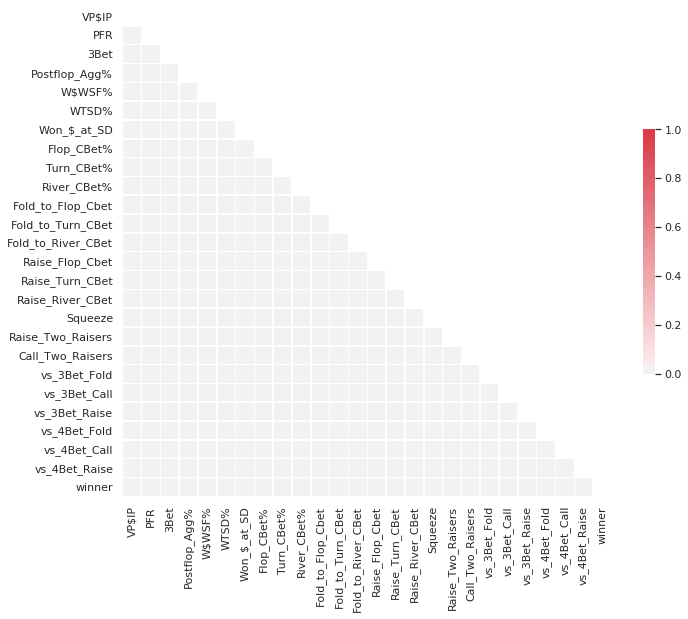

In [11]:
print_corr(df, pct=0.75)

_None of our features have more than 75 percent multicollinearities_

### Split the data between train and test datasets

In [12]:
labels = df["winner"]
df = df.drop(["winner"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.20, random_state=42)
X_train = X_train.reset_index().drop(["index"], axis=1)
y_train = y_train.reset_index().drop(["index"], axis=1)
X_test = X_test.reset_index().drop(["index"], axis=1)
y_test = y_test.reset_index().drop(["index"], axis=1)

## Baseline classifier using Logistic Regression

We are going to build a Logistic Regression model using a 5 fold cross validation as our baseline model

# Baseline Model using Logistic Regression Cross Validation

In [13]:
# Create a baseline model using Logistic Regression 5 Fold Cross Validation
baseline = LogisticRegressionCV(random_state=42, cv=5)

# Fit the baseline model
baseline.fit(X_train, y_train.values.ravel())

# Generate probabilities predictions from the baseline model
preds_proba = np.array(baseline.predict_proba(X_train))[:,1]

# Calculate baseline score using roc auc
baseline_score = get_roc_auc(y_train, preds_proba)

In [14]:
print(f"Baseline ROC AUC score: {round(baseline_score, 4)}")

0.8065115707068254

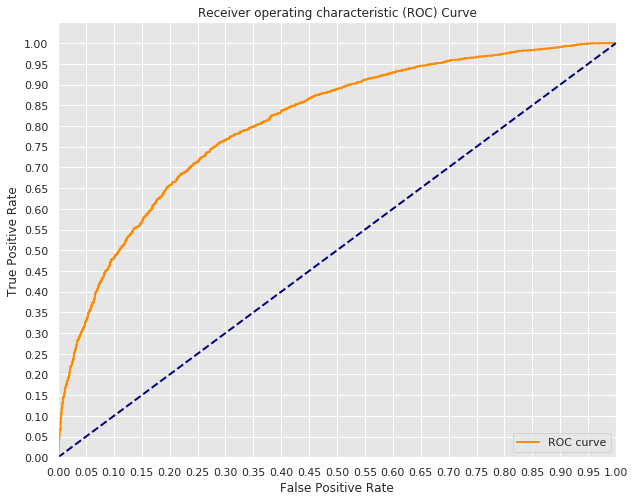

ROC AUC Score: 0.8065115707068254

------- Metrics for threshold 0.5 -------
- Precision Score: 0.7263863497867155
- Recall Score: 0.4790996784565916
- Accuracy Score: 0.7527277880119031
- F1 Score: 0.577379510777428



In [15]:
#Print the baseline's model ROC Curve and its metrics
metrics(y_train, preds_proba, plot=True)

# Feature Engineering

## Interactions

In [16]:
combinations = list(combinations(list(X_train.columns), 2))
interactions = []
data = X_train.copy()
for comb in combinations:
    
    # Instantiate a cross validation logistic regression model adding interactions to the train features
    regression = LogisticRegressionCV(random_state=42, cv=5)
    
    # Creating interaction
    data['interaction'] = data[comb[0]] * data[comb[1]]
    
    # Fit the model using new dataset containing the interaction
    regression.fit(data, y_train.values.ravel())
    
    # Generate probabilities predictions using the newly created model
    preds = np.array(regression.predict_proba(data))
    
    # Calculate the roc auc score for the newly created model
    score = get_roc_auc(y_train, preds[:,1])
    
    # Append the interaction combination and its score if the score of the model is better than the baseline model
    if score > baseline_score: interactions.append((comb[0], comb[1], round(score, 3)))
        
    # Drop the interaction 
    data.drop(["interaction"], axis=1, inplace=True)

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

In [17]:
interactions = sorted(interactions, key=lambda inter: inter[2], reverse=True)[:10]

In [18]:
pprint(interactions)

[('WTSD%', 'Won_$_at_SD', 0.813),
 ('Won_$_at_SD', 'River_CBet%', 0.809),
 ('Won_$_at_SD', 'Raise_Two_Raisers', 0.809),
 ('Won_$_at_SD', 'vs_4Bet_Call', 0.809),
 ('VP$IP', 'Won_$_at_SD', 0.808),
 ('VP$IP', 'Flop_CBet%', 0.808),
 ('VP$IP', 'Fold_to_River_CBet', 0.808),
 ('PFR', 'Flop_CBet%', 0.808),
 ('PFR', 'River_CBet%', 0.808),
 ('PFR', 'Fold_to_Turn_CBet', 0.808)]


Adding top 10 interactions to the datasets

In [19]:
for dataset in [X_train, X_test]:
    for interaction in interactions:
        col1 = interaction[0]
        col2 = interaction[1]
        colname = str(col1) + "_*_" + str(col2)
        dataset[colname] = dataset[col1] * dataset[col2]

In [20]:
X_train.head()

,VP$IP,PFR,3Bet,Postflop_Agg%,W$WSF%,WTSD%,Won_$_at_SD,Flop_CBet%,Turn_CBet%,River_CBet%,...,WTSD%_*_Won_$_at_SD,Won_$_at_SD_*_River_CBet%,Won_$_at_SD_*_Raise_Two_Raisers,Won_$_at_SD_*_vs_4Bet_Call,VP$IP_*_Won_$_at_SD,VP$IP_*_Flop_CBet%,VP$IP_*_Fold_to_River_CBet,PFR_*_Flop_CBet%,PFR_*_River_CBet%,PFR_*_Fold_to_Turn_CBet
0,0.217742,0.165323,0.043478,0.339623,0.461538,0.461538,0.583333,0.666667,0.500000,0.000000,...,0.269231,0.000000,0.000000,0.000000,0.127016,0.145161,0.000000,0.110215,0.000000,0.000000
1,0.529730,0.183784,0.026316,0.588710,0.590909,0.181818,0.500000,0.714286,0.000000,0.000000,...,0.090909,0.000000,0.000000,0.000000,0.264865,0.378378,0.000000,0.131274,0.000000,0.000000
2,0.367943,0.149903,0.083039,0.363300,0.553086,0.239506,0.453608,0.850000,0.714286,0.363636,...,0.108642,0.164948,0.010549,0.181443,0.166902,0.312751,0.091986,0.127417,0.054510,0.054964
3,0.260417,0.159722,0.056000,0.345455,0.436364,0.290909,0.437500,0.500000,0.800000,1.000000,...,0.127273,0.437500,0.000000,0.437500,0.113932,0.130208,0.000000,0.079861,0.159722,0.000000
4,0.272482,0.202425,0.080512,0.251121,0.431767,0.259508,0.560345,0.525974,0.321429,0.500000,...,0.145414,0.280172,0.013836,0.147459,0.152684,0.143319,0.155704,0.106470,0.101212,0.114708


## Polynomials

Checking which polynomials have the biggest impact once added to our baseline model

In [21]:
# We'll fit 3 different polynomial regression models from degree 2 to degree 4
columns = list(X_train.columns)
polynomials = []

# Loop over columns
for col in columns:
    for degree in [2, 3, 4]:
        
        # Create a copy of the train dataset
        data = X_train.copy()
        
        # Create Polynomial Transformer of a chosen degree
        poly = PolynomialFeatures(degree, include_bias=False)
        
        # Create new columns containing polynomials
        X_transformed = poly.fit_transform(X_train[[col]])
        
        # Adding polynomial features to the dataset
        data = pd.concat([data.drop(col, axis=1),pd.DataFrame(X_transformed)], axis=1)
        
        # Instantiate a cross validation logistic regression model adding polynomial transformed features
        lr = LogisticRegressionCV(random_state=42, cv=5)
        
        # Fit the new model using the newly created dataset containing polynomial features
        lr.fit(data, y_train.values.ravel())
        
        # Generate probabilities predictions
        preds = np.array(lr.predict_proba(data))
        
        # Calculate the roc auc score for the newly created model
        score = get_roc_auc(y_train, preds[:,1])
        
        # Append the polynomial feature and its score if the score of the model is better than the baseline model
        if score > baseline_score: polynomials.append((col, degree, round(score, 5)))

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Listing the top 10 polynomials into a dictionnary

In [22]:
polynomials = sorted(polynomials, key=lambda poly: poly[2], reverse=True)

In [23]:
polynomials_to_add = {}
for pol in polynomials:
    if pol[0] not in polynomials_to_add.keys():
        polynomials_to_add[pol[0]] = pol[1]
    if len(polynomials_to_add) == 10:
        break

In [24]:
pprint(polynomials_to_add)

{'3Bet': 3,
 'Fold_to_Turn_CBet': 3,
 'PFR': 3,
 'PFR_*_Flop_CBet%': 3,
 'Postflop_Agg%': 4,
 'Raise_Turn_CBet': 2,
 'Raise_Two_Raisers': 4,
 'Squeeze': 4,
 'VP$IP_*_Won_$_at_SD': 3,
 'Won_$_at_SD': 4}


Adding top 10 polynomials to X_train and X_test datasets

In [25]:
X_ = X_train.copy()
X_t = X_test.copy()
for col, degree in polynomials_to_add.items():
    
    #Instantiate PolynomialFeatures
    poly = PolynomialFeatures(degree, include_bias=False)
    
    #Fit and transform X_train
    X_poly_train = poly.fit_transform(np.array(X_[col]).reshape(-1, 1))
    X_poly_test = poly.transform(np.array(X_t[col]).reshape(-1, 1))
    
    #List column names including the original column
    colnames = [col]
    
    #Append polynomial columns names to list of columns names
    for deg in range(2, degree+1):
        colnames.append(str(col + "_^" + str(deg)))
        
    #Add polynomial columns to train and test data sets
    X_train = pd.concat([X_train.drop(col, axis=1),pd.DataFrame(X_poly_train, columns=colnames)], axis=1)
    X_test = pd.concat([X_test.drop(col, axis=1),pd.DataFrame(X_poly_test, columns=colnames)], axis=1)

In [26]:
X_train.head()

,VP$IP,W$WSF%,WTSD%,Flop_CBet%,Turn_CBet%,River_CBet%,Fold_to_Flop_Cbet,Fold_to_River_CBet,Raise_Flop_Cbet,Raise_River_CBet,...,Raise_Two_Raisers_^4,PFR,PFR_^2,PFR_^3,Fold_to_Turn_CBet,Fold_to_Turn_CBet_^2,Fold_to_Turn_CBet_^3,3Bet,3Bet_^2,3Bet_^3
0,0.217742,0.461538,0.461538,0.666667,0.500000,0.000000,0.285714,0.000000,0.285714,0.000000,...,0.000000e+00,0.165323,0.027332,0.004519,0.000000,0.000000,0.000000,0.043478,0.001890,0.000082
1,0.529730,0.590909,0.181818,0.714286,0.000000,0.000000,0.750000,0.000000,0.166667,0.000000,...,0.000000e+00,0.183784,0.033776,0.006208,0.000000,0.000000,0.000000,0.026316,0.000693,0.000018
2,0.367943,0.553086,0.239506,0.850000,0.714286,0.363636,0.452830,0.250000,0.056604,0.125000,...,2.925002e-07,0.149903,0.022471,0.003368,0.366667,0.134444,0.049296,0.083039,0.006895,0.000573
3,0.260417,0.436364,0.290909,0.500000,0.800000,1.000000,0.538462,0.000000,0.192308,0.000000,...,0.000000e+00,0.159722,0.025511,0.004075,0.000000,0.000000,0.000000,0.056000,0.003136,0.000176
4,0.272482,0.431767,0.259508,0.525974,0.321429,0.500000,0.535484,0.571428,0.064516,0.142857,...,3.716892e-07,0.202425,0.040976,0.008295,0.566667,0.321111,0.181963,0.080512,0.006482,0.000522


### Export X_train, X_test, y_train and y_test

In [27]:
X_train.to_csv('Datasets/X_train.csv', index = None, header=True)
X_test.to_csv('Datasets/X_test.csv', index = None, header=True)
y_train.to_csv('Datasets/y_train.csv', index = None, header=True)
y_test.to_csv('Datasets/y_test.csv', index = None, header=True)

### Import X_train, X_test, y_train and y_test

In [28]:
X_train = pd.read_csv("Datasets/X_train.csv")
X_test = pd.read_csv("Datasets/X_test.csv")
y_train = pd.read_csv("Datasets/y_train.csv")
y_test = pd.read_csv("Datasets/y_test.csv")
class_names = y_train.columns
X_train.head()

,VP$IP,W$WSF%,WTSD%,Flop_CBet%,Turn_CBet%,River_CBet%,Fold_to_Flop_Cbet,Fold_to_River_CBet,Raise_Flop_Cbet,Raise_River_CBet,...,Raise_Two_Raisers_^4,PFR,PFR_^2,PFR_^3,Fold_to_Turn_CBet,Fold_to_Turn_CBet_^2,Fold_to_Turn_CBet_^3,3Bet,3Bet_^2,3Bet_^3
0,0.217742,0.461538,0.461538,0.666667,0.500000,0.000000,0.285714,0.000000,0.285714,0.000000,...,0.000000e+00,0.165323,0.027332,0.004519,0.000000,0.000000,0.000000,0.043478,0.001890,0.000082
1,0.529730,0.590909,0.181818,0.714286,0.000000,0.000000,0.750000,0.000000,0.166667,0.000000,...,0.000000e+00,0.183784,0.033776,0.006208,0.000000,0.000000,0.000000,0.026316,0.000693,0.000018
2,0.367943,0.553086,0.239506,0.850000,0.714286,0.363636,0.452830,0.250000,0.056604,0.125000,...,2.925002e-07,0.149903,0.022471,0.003368,0.366667,0.134444,0.049296,0.083039,0.006895,0.000573
3,0.260417,0.436364,0.290909,0.500000,0.800000,1.000000,0.538462,0.000000,0.192308,0.000000,...,0.000000e+00,0.159722,0.025511,0.004075,0.000000,0.000000,0.000000,0.056000,0.003136,0.000176
4,0.272482,0.431767,0.259508,0.525974,0.321429,0.500000,0.535484,0.571428,0.064516,0.142857,...,3.716892e-07,0.202425,0.040976,0.008295,0.566667,0.321111,0.181963,0.080512,0.006482,0.000522


## Build pipelines

In [29]:
# Defining pipelines
pipe_knn = Pipeline([('mms', MinMaxScaler()),('knn', KNeighborsClassifier(n_neighbors=11))])
pipe_tree = Pipeline([('mms', MinMaxScaler()),('tree', DecisionTreeClassifier(max_depth=6, random_state=123))])
pipe_rf = Pipeline([('mms', MinMaxScaler()),('rf', RandomForestClassifier(max_depth=6, random_state=123))])

# List of pipelines, List of pipeline names
pipelines = [pipe_knn, pipe_tree, pipe_rf]
pipeline_names = ['K-Nearest Neighbors','Decision Tree','Random Forest']

# Fit the different models
for pipe in pipelines:
    pipe.fit(X_train, y_train.values.ravel())

/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



K-Nearest Neighbors pipeline metrics on train set:


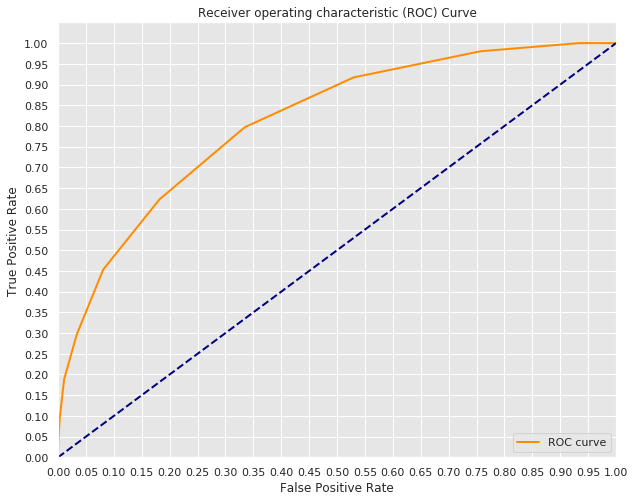

ROC AUC Score: 0.8114516762974864

------- Metrics for threshold 0.5 -------
- Precision Score: 0.753004005340454
- Recall Score: 0.4533762057877814
- Accuracy Score: 0.7548533371120872
- F1 Score: 0.5659809332664325



In [30]:
print(f"\n{pipeline_names[0]} pipeline metrics on train set:")
preds = np.array(pipelines[0].predict_proba(X_train))
metrics(y_train, preds[:,1], plot=True)


Decision Tree pipeline metrics on train set:


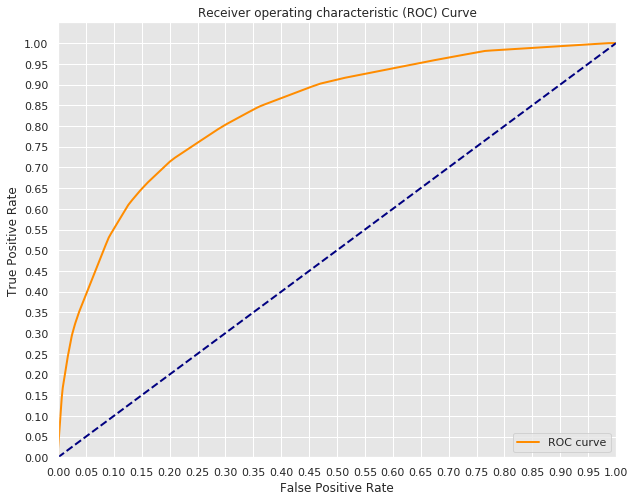

ROC AUC Score: 0.8343924771932195

------- Metrics for threshold 0.5 -------
- Precision Score: 0.7252273815222594
- Recall Score: 0.6089228295819936
- Accuracy Score: 0.7807850361343347
- F1 Score: 0.6620056805767971



In [31]:
print(f"\n{pipeline_names[1]} pipeline metrics on train set:")
preds = np.array(pipelines[1].predict_proba(X_train))
metrics(y_train, preds[:,1], plot=True)

Random Forest pipeline metrics on train set:


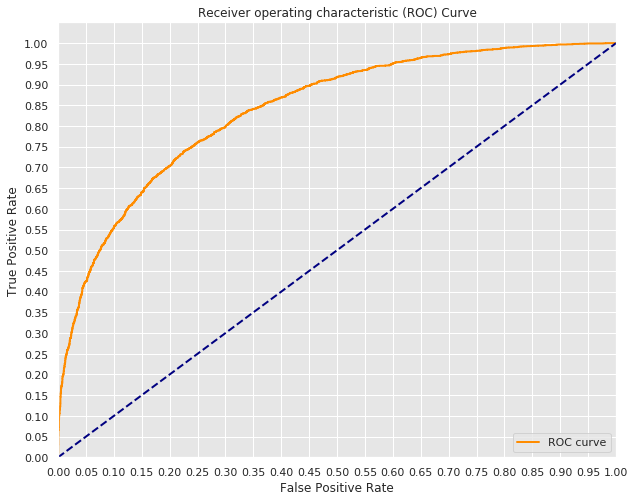

ROC AUC Score: 0.839360336927385

------- Metrics for threshold 0.5 -------
- Precision Score: 0.7405660377358491
- Recall Score: 0.5679260450160771
- Accuracy Score: 0.7775258608473856
- F1 Score: 0.6428571428571428



In [32]:
print(f"{pipeline_names[2]} pipeline metrics on train set:")
preds = np.array(pipelines[2].predict_proba(X_train))
metrics(y_train, preds[:,1], plot=True)

## K-Nearest-Neighbors Pipeline with Grid Search

In [33]:
# Construct pipeline
pipe_knn = Pipeline([('mms', MinMaxScaler()),('knn', KNeighborsClassifier())])

# Set grid search params
param_grid_knn = [
    {'knn__n_neighbors': list(range(1,100,2))
    }
]

# Construct grid search
gs_knn = GridSearchCV(estimator=pipe_knn, param_grid=param_grid_knn, scoring='roc_auc', cv=5, n_jobs=-1)

# Fit using grid search
gs_knn.fit(X_train, y_train.values.ravel())

# Save the knn model using the Pickle library
pickle.dump(gs_knn, open("knn_gdsearchCV5.p", "wb"))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('mms',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'knn


Grid search K-Nearest Neighbors metrics on train set


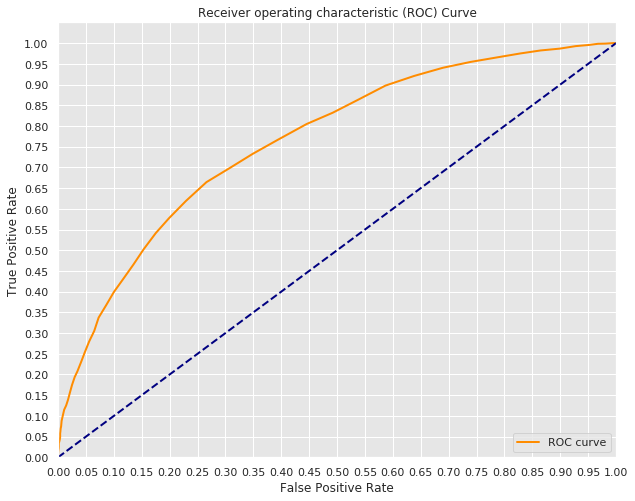

ROC AUC Score: 0.7650225129648357

------- Metrics for threshold 0.5 -------
- Precision Score: 0.7423529411764705
- Recall Score: 0.25361736334405144
- Accuracy Score: 0.7058240045345048
- F1 Score: 0.378070701018574


Validation ROC AUC: 0.742

Best params:
 {'knn__n_neighbors': 81}


In [34]:
preds_knn = np.array(gs_knn.predict_proba(X_train))

print("\nGrid search K-Nearest Neighbors metrics on train set")
metrics(y_train, preds_knn[:,1], plot=True)

# Validation ROC AUC
print('\nValidation ROC AUC: %.3f' % gs_knn.best_score_)

# Best params
print('\nBest params:\n', gs_knn.best_params_)

## Random Forest Classifier Pipeline with Grid Search

In [71]:
# Construct pipeline
pipe_rf = Pipeline([('mms', MinMaxScaler()),('rf', RandomForestClassifier(random_state=123))])

# Set grid search params
param_grid_forest = [
    {'rf__n_estimators': [10, 20],
     'rf__criterion': ['entropy'],
     'rf__max_depth': [3, 4, 5, 6],
     'rf__max_features': [5, 15, 25, 35, 45]
    }
]

# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf, param_grid=param_grid_forest, scoring='roc_auc', cv=5, verbose=2, return_train_score=True)

# Fit using grid search
gs_rf.fit(X_train, y_train.values.ravel())

# Save the RandomForestClassifier model using the Pickle library
pickle.dump(gs_rf, open("random_forest_gdsearchCV5.p", "wb"))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] rf__criterion=entropy, rf__max_depth=3, rf__max_features=5, rf__n_estimators=10 
[CV]  rf__criterion=entropy, rf__max_depth=3, rf__max_features=5, rf__n_estimators=10, total=   0.1s
[CV] rf__criterion=entropy, rf__max_depth=3, rf__max_features=5, rf__n_estimators=10 
[CV]  rf__criterion=entropy, rf__max_depth=3, rf__max_features=5, rf__n_estimators=10, total=   0.1s
[CV] rf__criterion=entropy, rf__max_depth=3, rf__max_features=5, rf__n_estimators=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  rf__criterion=entropy, rf__max_depth=3, rf__max_features=5, rf__n_estimators=10, total=   0.1s
[CV] rf__criterion=entropy, rf__max_depth=3, rf__max_features=5, rf__n_estimators=10 
[CV]  rf__criterion=entropy, rf__max_depth=3, rf__max_features=5, rf__n_estimators=10, total=   0.1s
[CV] rf__criterion=entropy, rf__max_depth=3, rf__max_features=5, rf__n_estimators=10 
[CV]  rf__criterion=entropy, rf__max_depth=3, rf__max_features=5, rf__n_estimators=10, total=   0.1s
[CV] rf__criterion=entropy, rf__max_depth=3, rf__max_features=5, rf__n_estimators=20 
[CV]  rf__criterion=entropy, rf__max_depth=3, rf__max_features=5, rf__n_estimators=20, total=   0.1s
[CV] rf__criterion=entropy, rf__max_depth=3, rf__max_features=5, rf__n_estimators=20 
[CV]  rf__criterion=entropy, rf__max_depth=3, rf__max_features=5, rf__n_estimators=20, total=   0.1s
[CV] rf__criterion=entropy, rf__max_depth=3, rf__max_features=5, rf__n_estimators=20 
[CV]  rf__criterion=entropy, rf__max_depth=3, rf__max_features=5,

[CV]  rf__criterion=entropy, rf__max_depth=3, rf__max_features=45, rf__n_estimators=20, total=   0.7s
[CV] rf__criterion=entropy, rf__max_depth=3, rf__max_features=45, rf__n_estimators=20 
[CV]  rf__criterion=entropy, rf__max_depth=3, rf__max_features=45, rf__n_estimators=20, total=   0.7s
[CV] rf__criterion=entropy, rf__max_depth=3, rf__max_features=45, rf__n_estimators=20 
[CV]  rf__criterion=entropy, rf__max_depth=3, rf__max_features=45, rf__n_estimators=20, total=   0.9s
[CV] rf__criterion=entropy, rf__max_depth=3, rf__max_features=45, rf__n_estimators=20 
[CV]  rf__criterion=entropy, rf__max_depth=3, rf__max_features=45, rf__n_estimators=20, total=   0.8s
[CV] rf__criterion=entropy, rf__max_depth=4, rf__max_features=5, rf__n_estimators=10 
[CV]  rf__criterion=entropy, rf__max_depth=4, rf__max_features=5, rf__n_estimators=10, total=   0.1s
[CV] rf__criterion=entropy, rf__max_depth=4, rf__max_features=5, rf__n_estimators=10 
[CV]  rf__criterion=entropy, rf__max_depth=4, rf__max_feat

[CV]  rf__criterion=entropy, rf__max_depth=4, rf__max_features=45, rf__n_estimators=10, total=   0.6s
[CV] rf__criterion=entropy, rf__max_depth=4, rf__max_features=45, rf__n_estimators=10 
[CV]  rf__criterion=entropy, rf__max_depth=4, rf__max_features=45, rf__n_estimators=10, total=   0.5s
[CV] rf__criterion=entropy, rf__max_depth=4, rf__max_features=45, rf__n_estimators=10 
[CV]  rf__criterion=entropy, rf__max_depth=4, rf__max_features=45, rf__n_estimators=10, total=   0.6s
[CV] rf__criterion=entropy, rf__max_depth=4, rf__max_features=45, rf__n_estimators=10 
[CV]  rf__criterion=entropy, rf__max_depth=4, rf__max_features=45, rf__n_estimators=10, total=   0.5s
[CV] rf__criterion=entropy, rf__max_depth=4, rf__max_features=45, rf__n_estimators=10 
[CV]  rf__criterion=entropy, rf__max_depth=4, rf__max_features=45, rf__n_estimators=10, total=   0.6s
[CV] rf__criterion=entropy, rf__max_depth=4, rf__max_features=45, rf__n_estimators=20 
[CV]  rf__criterion=entropy, rf__max_depth=4, rf__max_f

[CV]  rf__criterion=entropy, rf__max_depth=5, rf__max_features=35, rf__n_estimators=10, total=   0.5s
[CV] rf__criterion=entropy, rf__max_depth=5, rf__max_features=35, rf__n_estimators=20 
[CV]  rf__criterion=entropy, rf__max_depth=5, rf__max_features=35, rf__n_estimators=20, total=   1.0s
[CV] rf__criterion=entropy, rf__max_depth=5, rf__max_features=35, rf__n_estimators=20 
[CV]  rf__criterion=entropy, rf__max_depth=5, rf__max_features=35, rf__n_estimators=20, total=   0.9s
[CV] rf__criterion=entropy, rf__max_depth=5, rf__max_features=35, rf__n_estimators=20 
[CV]  rf__criterion=entropy, rf__max_depth=5, rf__max_features=35, rf__n_estimators=20, total=   0.9s
[CV] rf__criterion=entropy, rf__max_depth=5, rf__max_features=35, rf__n_estimators=20 
[CV]  rf__criterion=entropy, rf__max_depth=5, rf__max_features=35, rf__n_estimators=20, total=   0.9s
[CV] rf__criterion=entropy, rf__max_depth=5, rf__max_features=35, rf__n_estimators=20 
[CV]  rf__criterion=entropy, rf__max_depth=5, rf__max_f

[CV]  rf__criterion=entropy, rf__max_depth=6, rf__max_features=25, rf__n_estimators=20, total=   0.9s
[CV] rf__criterion=entropy, rf__max_depth=6, rf__max_features=25, rf__n_estimators=20 
[CV]  rf__criterion=entropy, rf__max_depth=6, rf__max_features=25, rf__n_estimators=20, total=   0.8s
[CV] rf__criterion=entropy, rf__max_depth=6, rf__max_features=35, rf__n_estimators=10 
[CV]  rf__criterion=entropy, rf__max_depth=6, rf__max_features=35, rf__n_estimators=10, total=   0.6s
[CV] rf__criterion=entropy, rf__max_depth=6, rf__max_features=35, rf__n_estimators=10 
[CV]  rf__criterion=entropy, rf__max_depth=6, rf__max_features=35, rf__n_estimators=10, total=   0.6s
[CV] rf__criterion=entropy, rf__max_depth=6, rf__max_features=35, rf__n_estimators=10 
[CV]  rf__criterion=entropy, rf__max_depth=6, rf__max_features=35, rf__n_estimators=10, total=   0.6s
[CV] rf__criterion=entropy, rf__max_depth=6, rf__max_features=35, rf__n_estimators=10 
[CV]  rf__criterion=entropy, rf__max_depth=6, rf__max_f

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.6min finished


In [ ]:
# Load RandomForestClassifier model using pickle
gs_rf = pickle.load(open("random_forest_gdsearchCV5.p", "rb"))


Grid search Random Forest Classifier metrics on train set


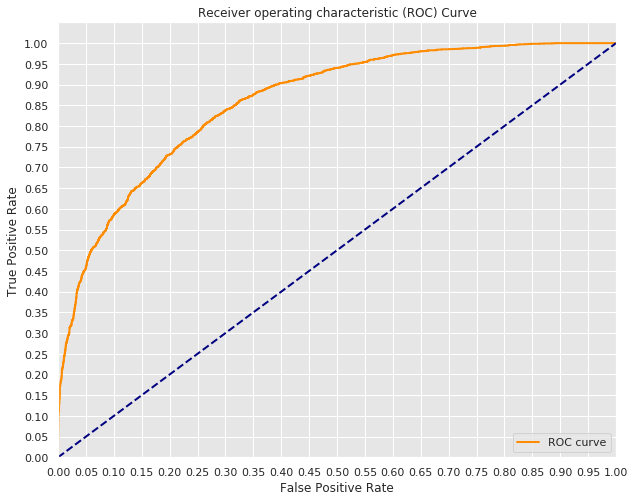

ROC AUC Score: 0.8591299520253575

------- Metrics for threshold 0.5 -------
- Precision Score: 0.7353652636671505
- Recall Score: 0.6109324758842444
- Accuracy Score: 0.7853195408813943
- F1 Score: 0.6673984632272228


The validation ROC AUC is: 0.809

Best params:
 {'rf__criterion': 'entropy', 'rf__max_depth': 6, 'rf__max_features': 45, 'rf__n_estimators': 20}


In [38]:
# Generate probabilities predictions using our RandomForestClassifier
preds_rf = np.array(gs_rf.predict_proba(X_train))

print("\nGrid search Random Forest Classifier metrics on TRAIN DATASET")
metrics(y_train, preds_rf[:,1], plot=True)

# Validation ROC AUC
print('\nThe validation ROC AUC is: %.3f' % gs_rf.best_score_)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

## XGBoost Classifier Pipeline with Grid Search

In [41]:
# Construct XGBoost pipeline
pipe_xgb = Pipeline([('mms', MinMaxScaler()),('xgb', XGBClassifier(random_state=123))])

# Set grid search params
param_grid_xgb = {
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5, 6]
}

# Construct grid search
gs_xgb = GridSearchCV(estimator=pipe_xgb, param_grid=param_grid_xgb, scoring='roc_auc', cv=5, verbose=0, return_train_score=True)

# Fit using grid search
gs_xgb.fit(X_train, y_train.values.ravel())

# Save the XGBoost model using the Pickle library
pickle.dump(gs_xgb, open("xgboost_gdsearchCV5.p", "wb"))

In [42]:
# Load XGBoost model using pickle
gs_xgb = pickle.load(open("xgboost_gdsearchCV5.p", "rb"))

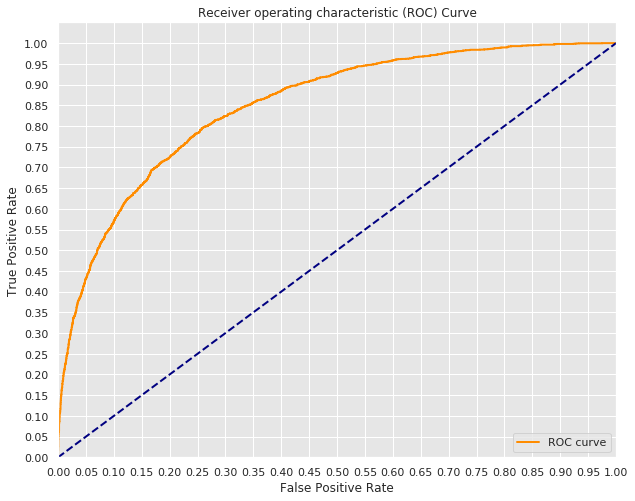

----------------------------------------------------------------------------------------------------

Grid search XGBoost Classifier metrics on TRAIN DATASET
ROC AUC Score: 0.849149676380529

------- Metrics for threshold 0.5 -------
- Precision Score: 0.7391937833899952
- Recall Score: 0.6117363344051447
- Accuracy Score: 0.7870199801615417
- F1 Score: 0.669452386188696

----------------------------------------------------------------------------------------------------

Grid search XGBoost Classifier metrics on TEST DATASET

ROC AUC Score: 0.8025960280856337

------- Metrics for threshold 0.5 -------
- Precision Score: 0.6450304259634888
- Recall Score: 0.5326633165829145
- Accuracy Score: 0.7427762039660056
- F1 Score: 0.58348623853211

----------------------------------------------------------------------------------------------------
Validation ROC AUC: 0.813
----------------------------------------------------------------------------------------------------

Best parameters for X

In [45]:
# Generate probabilities predictions from our Train and Test datasets using our XGBoost Classifier
preds_proba_xgb = np.array(gs_xgb.predict_proba(X_train))[:,1]
preds_proba_xgb_test = np.array(gs_xgb.predict_proba(X_test))[:,1]

# Plot ROC curve for based on the train dataset
metrics(y_train, preds_proba_xgb, plot=True, print_metrics=False)
print(f"{'-'*100}")

print("\nGrid search XGBoost Classifier metrics on TRAIN DATASET")
metrics(y_train, preds_proba_xgb, plot=False)
print(f"{'-'*100}")
      
print("\nGrid search XGBoost Classifier metrics on TEST DATASET\n")
metrics(y_test, preds_proba_xgb_test, plot=False)
print(f"{'-'*100}")

# Validation ROC AUC
print('Validation ROC AUC: %.3f' % gs_xgb.best_score_)
print(f"{'-'*100}")

# Best params
print('\nBest parameters for XGBoost:\n', gs_xgb.best_params_)

### Plotting XGBoost Tree

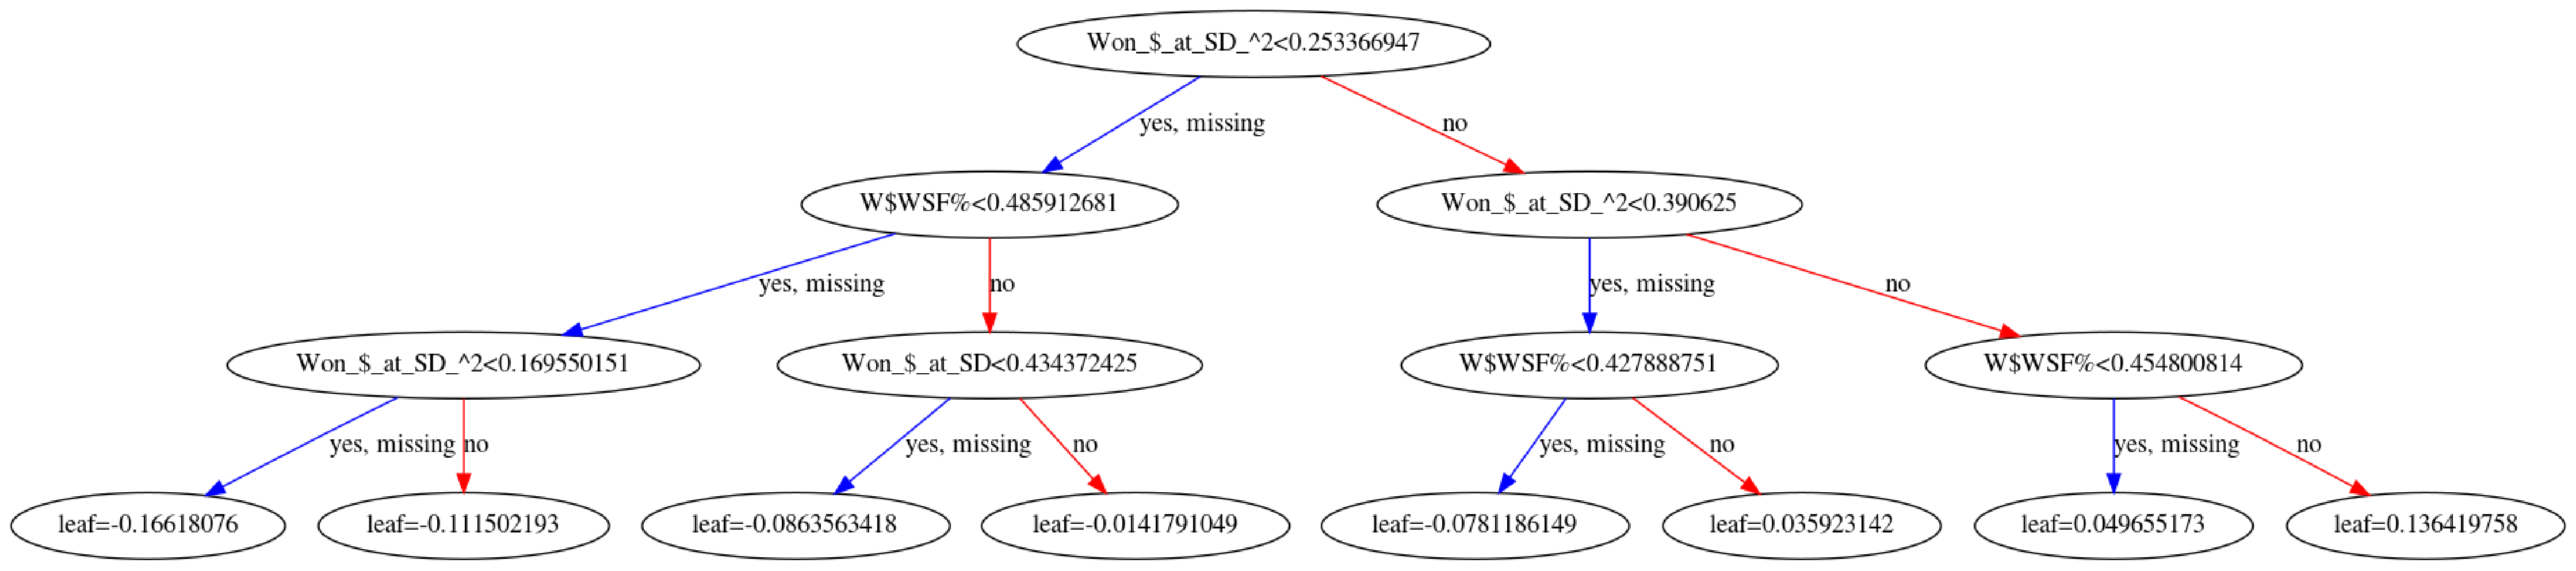

In [46]:
# Create a new XGBoost model using the best parameters found using GridSearchCV
xgb_clf = XGBClassifier(**gs_xgb.best_params_, random_state=123)

# Fit the XGBoost model
xgb_clf.fit(X_train, y_train.values.ravel())

# Define figure size
rcParams['figure.figsize'] = 80,120

# Plot XGBoost tree
plot_tree(xgb_clf)

# - First objective: classify good players accuretely in small stakes games

When playing a small stakes game we know that most players are probably losing players, to the point that we can consider players as losing player by default.
Knowing this we would like to recognize the winning players in order to avoid playing against them.

Since we don't want to miss value by not playing against a player that was miss classified as a good player we need to be quite certain that our classifier will tell us that a player is a winning player when he actually is!

### Calculating optimal threshold for small stakes

In [64]:
# Defining prevalence
prevalence = 0.25 # The prevalence for good players in small stakes games should be around 25 percent
CostFP_minus_CostTN = 12
CostFN_minus_CostTP = 6

# Calculating the optimal threshold for small stakes games
threshold_small_stakes = threshold_selection(prevalence, CostFP_minus_CostTN, CostFN_minus_CostTP, y=y_train, y_hat=preds_proba_xgb)
print("Threshold small stakes:", round(threshold_small_stakes, 3))

Threshold small stakes: 0.696


### Plotting Confusion Matrix for small stakes

Normalized confusion matrix
[[0.97307945 0.02692055]
 [0.66639871 0.33360129]]


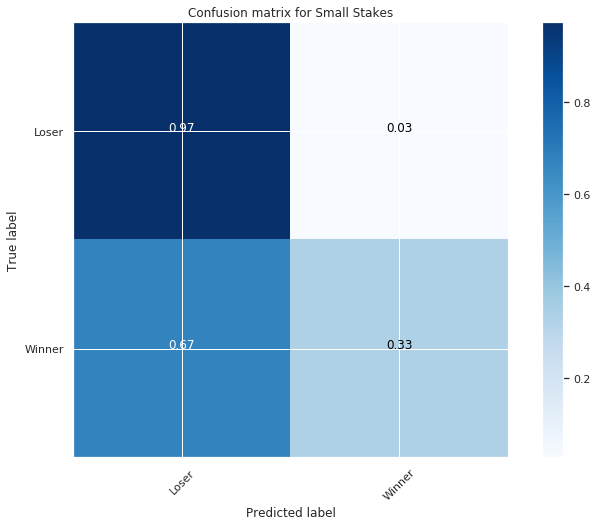

Precision score for winners: 0.87 %


In [66]:
# Plot the normalized confusion matrix for our optimal threshold
class_names = ["Loser", "Winner"]
preds_proba = np.array(gs_xgb.predict_proba(X_train))[:,1]
plt.figure(figsize=(12,8))
cm_s = plot_confusion_matrix(labels=y_train, preds_proba=preds_proba, threshold=threshold_small_stakes, classes=class_names, normalize=True, title='Confusion matrix for Small Stakes')
print(f"Precision score for winners: {round(cm_s[1][1] / (cm_s[0][1] + cm_s[1][1]), 2)} %")

### Conclusion small stakes

- Our classifier will only tell us a third of the actual winners on the table but will make few mistakes (around 13% of the time) when predicting winning players.

# - Second objective: classify bad players accuretely in high stakes games

When playing a high stakes game we know that most players are winning players.
Knowing this we would like to recognize the winning players in order to avoid playing against them.

Since we don't want to miss value by not playing against a player that was miss classified as a good player we need to be quite certain that our classifier will tell us that a player is a winning player when he actually is!

## Calculating optimal threshold for high stakes

In [67]:
# Defining prevalence
prevalence = 0.75 # The prevalence for good players in high stakes games should be around 75 percent
CostFP_minus_CostTN = 12
CostFN_minus_CostTP = 4

# Calculating the optimal threshold for high stakes games
threshold_high_stakes = threshold_selection(prevalence, CostFP_minus_CostTN, CostFN_minus_CostTP, y=y_train, y_hat=preds_proba_xgb)
print("Threshold high stakes:", round(threshold_high_stakes, 3))

Threshold high stakes: 0.326


## Plotting Confusion Matrix for high stakes

Normalized confusion matrix
[[0.73954914 0.26045086]
 [0.20337621 0.79662379]]


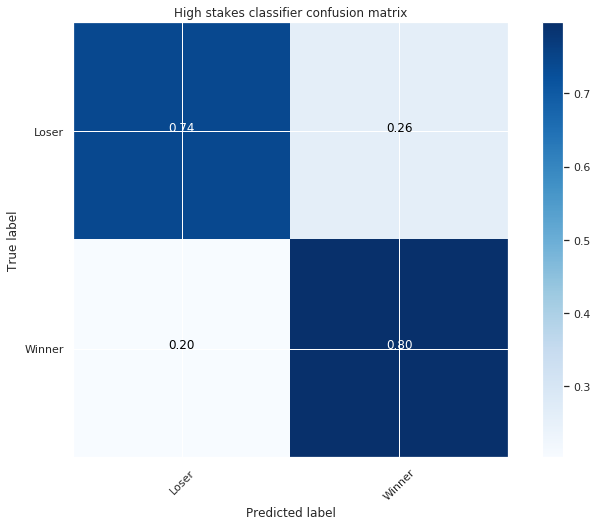

Precision score for losers: 0.87 %


In [70]:
# Plot a normalized confusion matrix
class_names = ["Loser", "Winner"]
preds_proba = np.array(gs_xgb.predict_proba(X_train))[:,1]
plt.figure(figsize=(12,8))
cm_h = plot_confusion_matrix(labels=y_train, preds_proba=preds_proba, threshold=threshold_high_stakes, classes=class_names, normalize=True, title='High stakes classifier confusion matrix')
print(f"Precision score for losers: {round(cm_h[0][0] / (cm_h[0][0] + cm_h[1][0]), 2)} %")

### Conclusion regarding high stakes classifier

- Our classifier will tell us 74 percent of the losers on the table and will make very few mistakes (around 13% of the time) when predicting losing players

In [ ]:
df_X = pd.read_csv("Poker.csv", encoding='latin-1')
X = df_X.iloc[0].to_frame().T
X.head()

In [ ]:
scaler = pipe_xgb.named_steps['mms']
scaler.fit(X_train)

In [ ]:
for i in range(20):
    X = df_X.iloc[i].to_frame().T
    class_predicted = prediction(X=X, scaler=scaler, model=gs_xgb, stakes="small")
    print(f"class_predicted {class_predicted}")

In [ ]:
preds_proba

# Conclusions

TODO

comment notebook

visualisation trees

prediction function

readme

slides